# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [108]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.dbc84c53891f41e7a694ba83cac91506/status,


In [111]:
client.close()
cluster.close()

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
import fastjmd95
import json

In [2]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)

In [3]:
#fix time dim (1896/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [4]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "gs://pangeo-tmp/stb2145/models/SODA/"
    return xr.open_dataset((path + filename), engine="zarr", backend_kwargs={"storage_options": {"token": token}})

transport = open_ds('transport_wg.zarr')
cells = open_ds('cells_wg.zarr')
surf = open_ds('surf_terms.zarr')
totend = open_ds('totend.zarr')

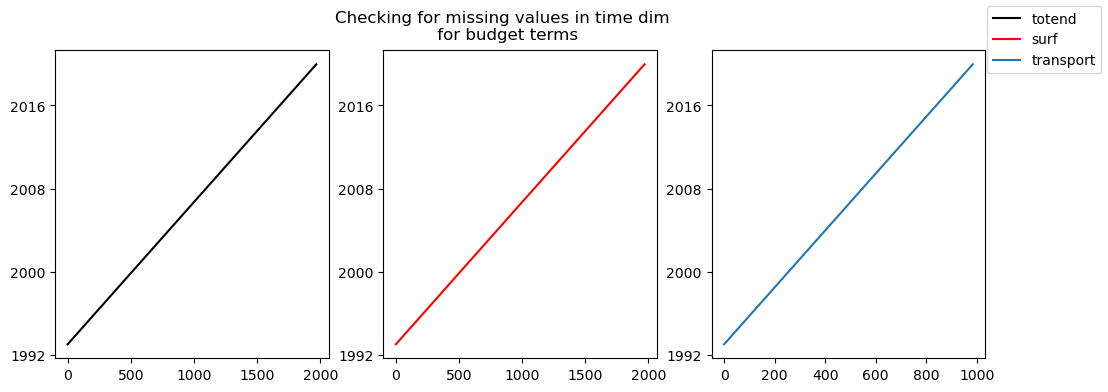

In [8]:
#check that time dim doesn't have missing value dates for budget terms
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(12,4))
ax0.plot(totend.time.values, label='totend', c='k') #every 5 days
ax1.plot(surf.time.values, label='surf', c='r') #every 5 days
ax2.plot(transport.time.values, label='transport') #every 10 days
plt.suptitle('Checking for missing values in time dim \n for budget terms')
fig.legend();

## <font color='Green'>Slice to WG region</font>

In [5]:
#WG boundaries (80˚S, 57˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 208 #right exclusive so it'll stop at -57.225204
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 208 #-57.15741334
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [6]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [7]:
ds_wg = ocean.isel(**lat_range, **lon_range)

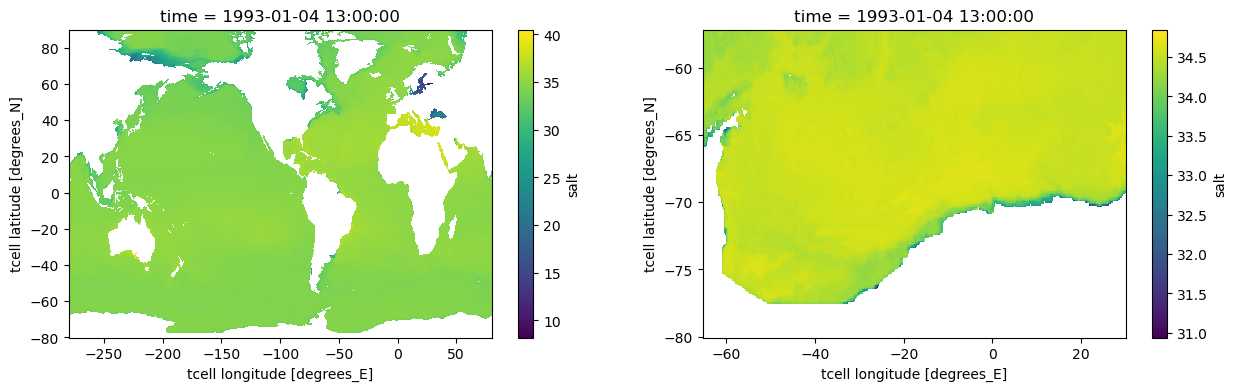

In [12]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ocean.salt.mean('st_ocean')[0].plot(ax=ax0)
ds_wg.salt.mean('st_ocean')[0].plot(ax=ax1)

In [8]:
#mask our the acc in the corner
mask = xr.ones_like(ds_wg.temp[0])
mask1 = xr.ones_like(ds_wg.temp[0])

In [9]:
mask[:, 159:None, None:41] = 0
mask[:, 149:159, None:30] = 0
mask[:, 123:149, None:16] = 0
mask1[:, 123:None, None:30] = 0

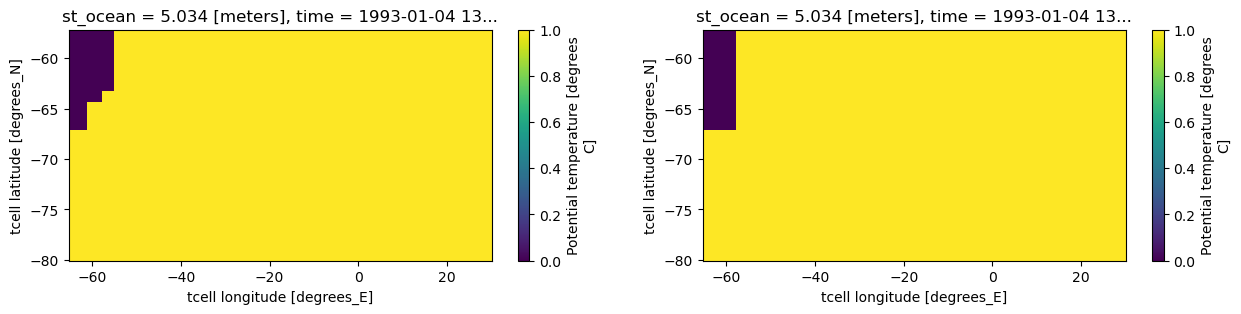

In [11]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,3))

mask[0].plot(ax=ax0)
mask1[0].plot(ax=ax1)

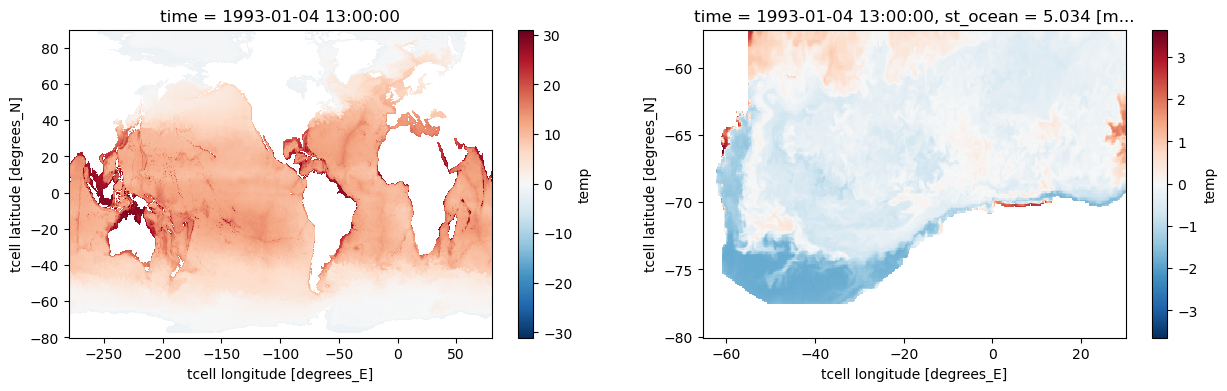

In [285]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ocean.temp.mean('st_ocean')[0].plot(ax=ax0)
ds_wg.temp.mean('st_ocean')[0].where(mask).plot(ax=ax1);

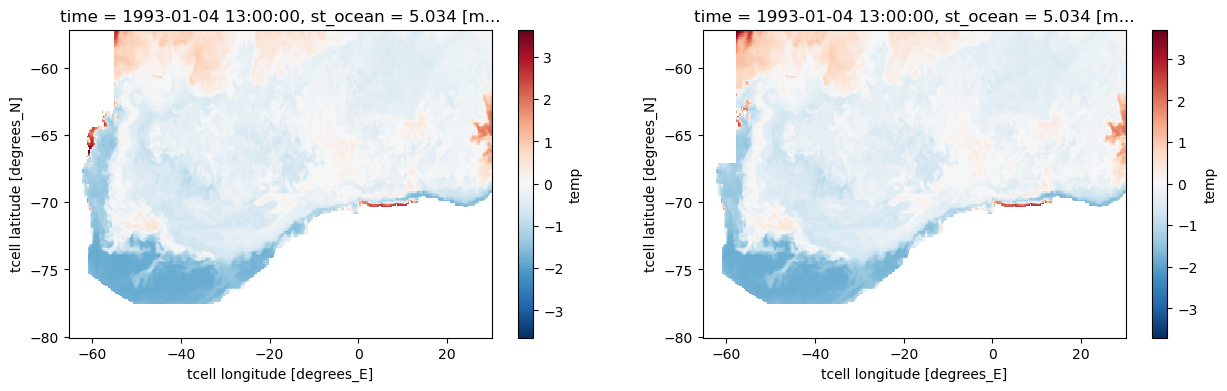

In [286]:
#use mask not mask1
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ds_wg.temp.mean('st_ocean')[0].where(mask).plot(ax=ax0)
ds_wg.temp.mean('st_ocean')[0].where(mask1).plot(ax=ax1);

## Correcting for two spikes in salt data
In late 1993 and late 2018

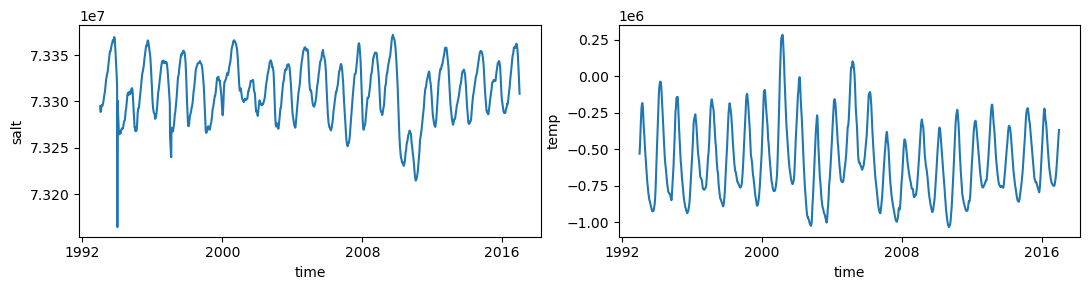

In [19]:
#spike in salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

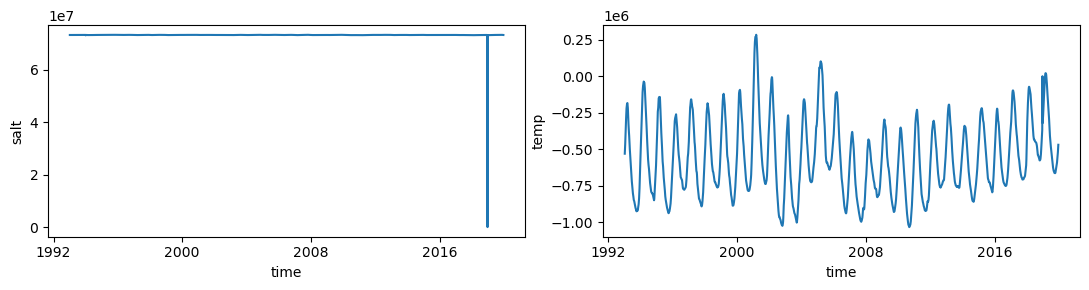

In [20]:
#another spike in salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

In [10]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp

#2018
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

#1993
salt25 = ds_wg.salt.sel(time='1993-12-25').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})
salt04 = ds_wg.salt.sel(time='1994-01-04').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})

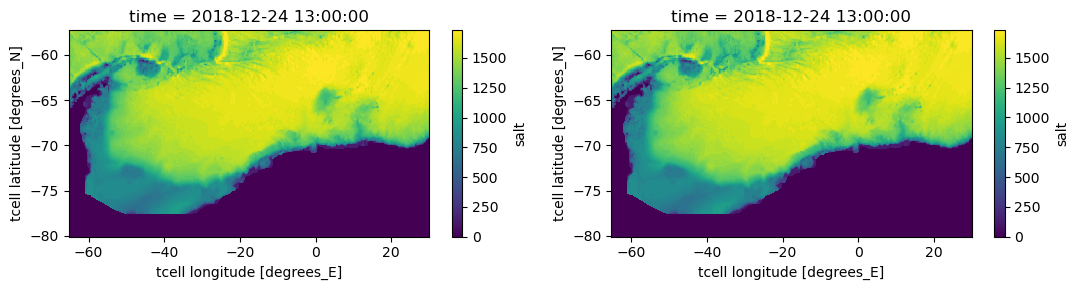

In [22]:
#plotting what each endpt date looks like - salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

salt19.salt.sum('st_ocean').plot(ax=ax0)
salt29.salt.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

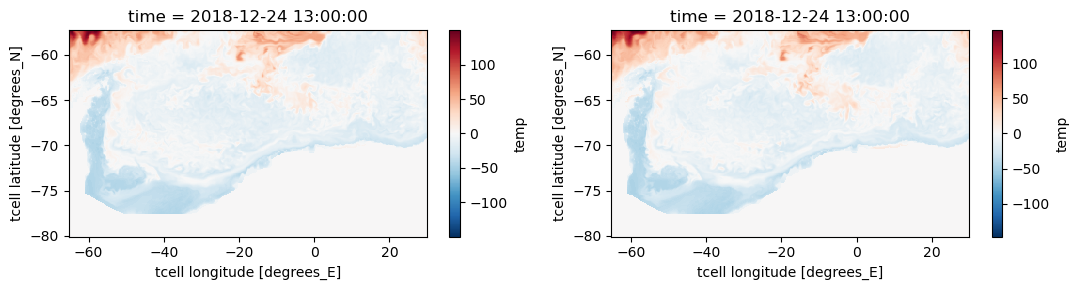

In [23]:
#plotting what each endpt date looks like - temp
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

temp19.temp.sum('st_ocean').plot(ax=ax0)
temp29.temp.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

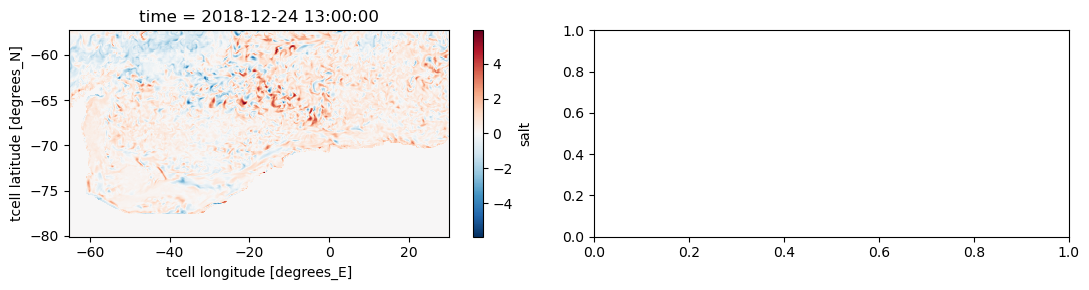

In [24]:
#plotting diff between dates - salt (left) & temp (right)
fig, (ax0,ax10) = plt.subplots(1,2, figsize=(11,3))
(salt19.salt - salt29.salt).sum('st_ocean').plot(ax=ax0)
(temp19.temp - temp29.temp).sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

In [11]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

#avging the two endpts to insert onto 1993-12-30 since there is a spike on that date due to nudging
salt30_ds = (salt25+salt04)/2
salt30 = salt30_ds.salt

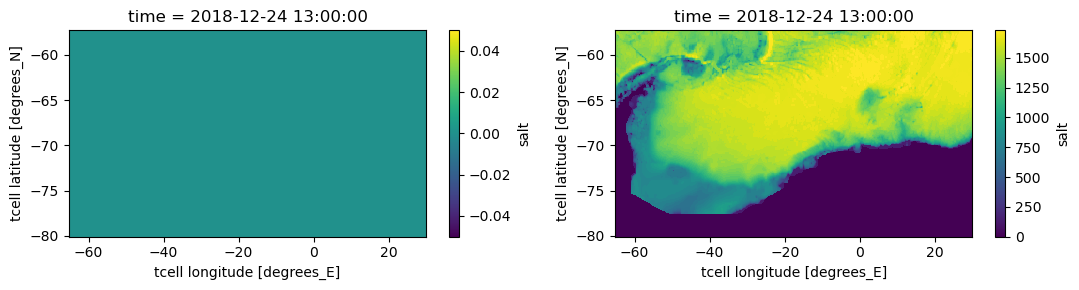

In [26]:
#plotting salt on 12-24 in ds_wg before inserting avged salt with 12-24 timestamp - salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.salt.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
salt24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

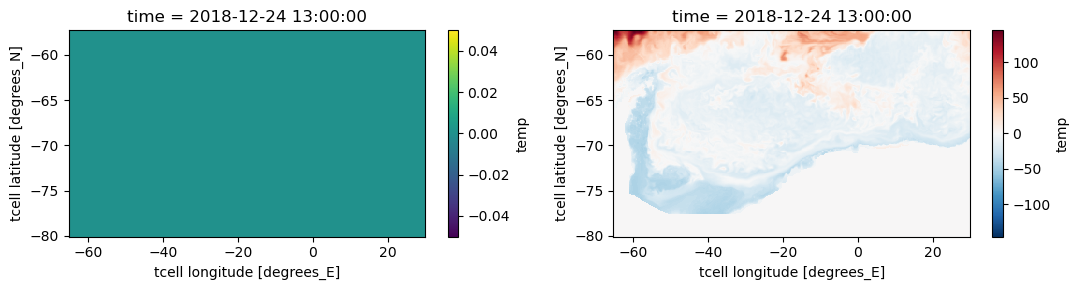

In [27]:
#plotting temp on 12-24 in ds_wg before inserting avged salt with 12-24 timestamp - temp
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.temp.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
temp24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

In [12]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

#inserting avged salt value on 1993-12-30 date into ds_wg
ds_wg['salt'][72] = salt30[0]

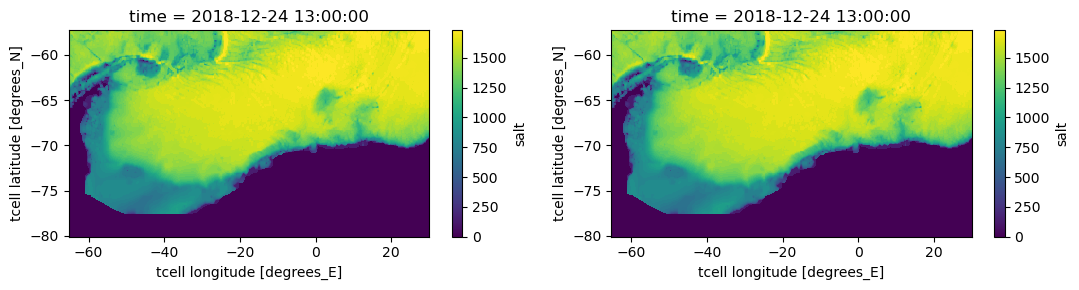

In [29]:
#success! - ds_wg.salt now has avged values of dates 12-19 & 12-29 on 12-24 - salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.salt.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
salt24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

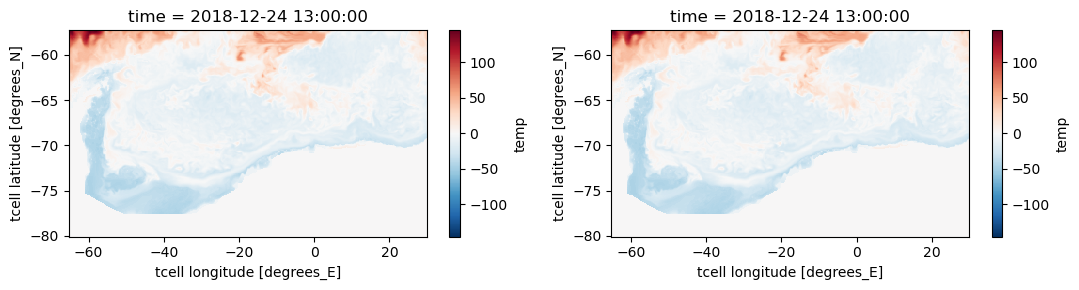

In [30]:
#success! - ds_wg.temp now has avged values of dates 12-19 & 12-29 on 12-24 - temp
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.temp.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
temp24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

In [13]:
#adjusting for another spike in jan1997

#going to insert avg'd values from dec & feb into jan
dec = ds_wg.salt.sel(time='1996-12')
jan = ds_wg.salt.sel(time='1997-01')
feb = ds_wg.salt.sel(time='1997-02')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into ds_wg
for i in range(6):
    for j in jan_range:
        ds_wg.salt[j] = jan[i]

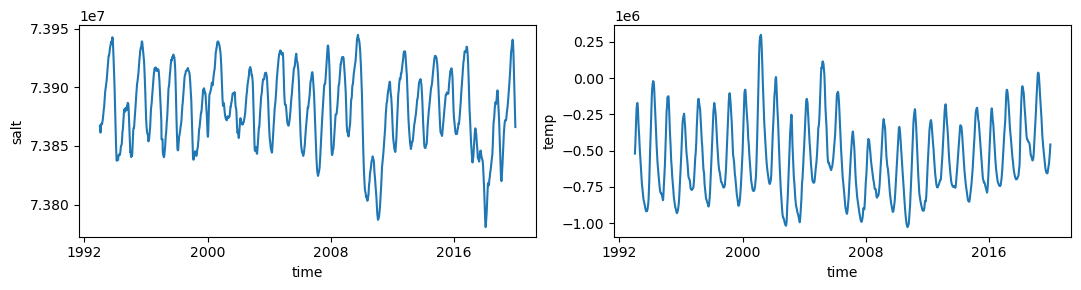

In [17]:
#checking spike again - success! no more spikes in salt or missing data in 2018
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

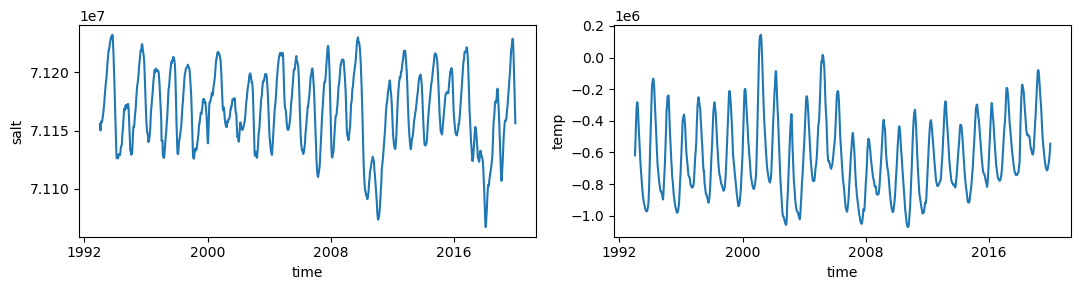

In [18]:
#checking spike again - success! no more spikes in salt or missing data in 2018
#checking to see if mask has significant influence over magnitude
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.where(mask).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.where(mask).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [14]:
pref = 2000
sigma2 = fastjmd95.rho(ds_wg.salt.where(mask), ds_wg.temp.where(mask), pref)

In [15]:
sigma2

,Array,Chunk
Bytes,58.16 GiB,30.23 MiB
Shape,"(1970, 50, 208, 381)","(1, 50, 208, 381)"
Count,55 Graph Layers,1970 Chunks
Type,float64,numpy.ndarray


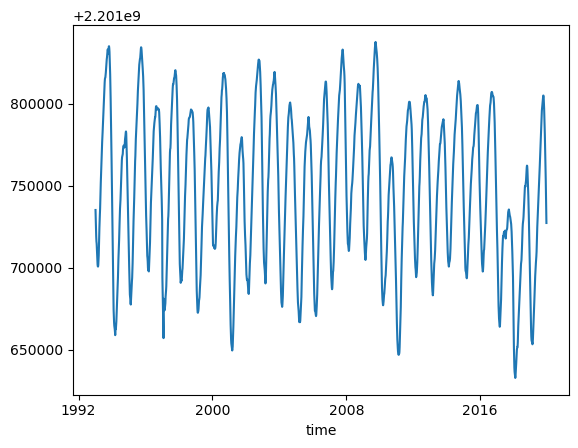

In [49]:
sigma2.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

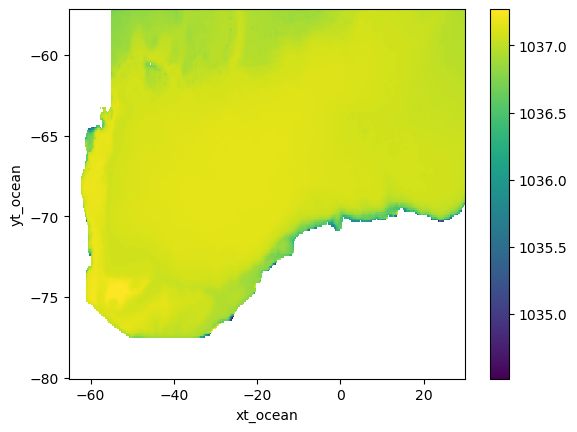

In [83]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [84]:
sigma2.nbytes/1e9

62.447424

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [16]:
drhodt = fastjmd95.drhodt(ds_wg.salt.where(mask), ds_wg.temp.where(mask), pref)
drhods = fastjmd95.drhods(ds_wg.salt, ds_wg.temp, pref)

In [17]:
vol_unmasked = cells.dx_interp * cells.dy_u * cells.dz
vol = vol_unmasked.where(mask)

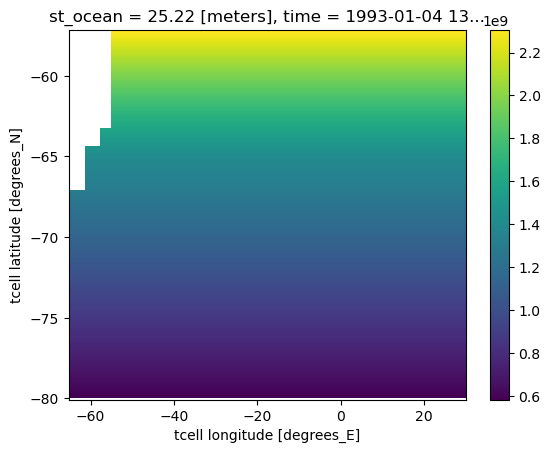

In [87]:
vol.isel(st_ocean=2).T.plot()

In [88]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [89]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [90]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [18]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

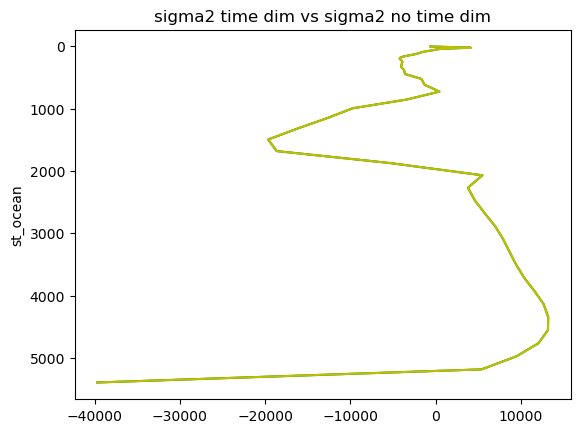

In [59]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

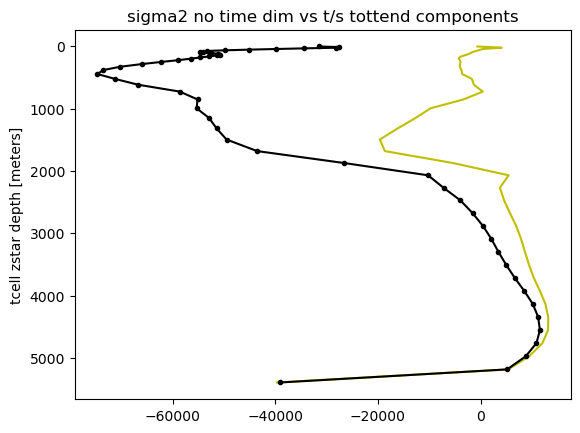

In [60]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

In [19]:
# out of the 3 options above, choosing tottend term to be defined as:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:]).drop('dt')#.load()

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

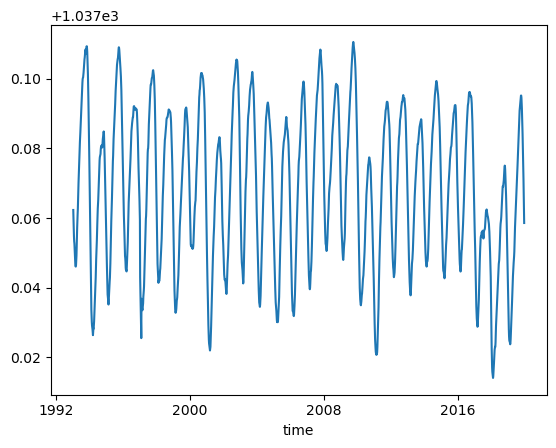

In [64]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [20]:
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [94]:
sigma_bins.size

700

In [95]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.fa03df1225b74cfda5668e621539aa24/status,


In [96]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [97]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

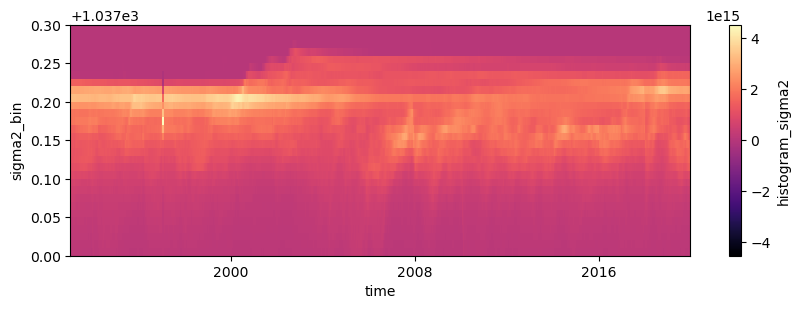

In [98]:
sigma_dist.plot(x='time', figsize=(10,3), cmap='magma')
plt.ylim(1037, 1037.3)

(1037.0, 1037.3)

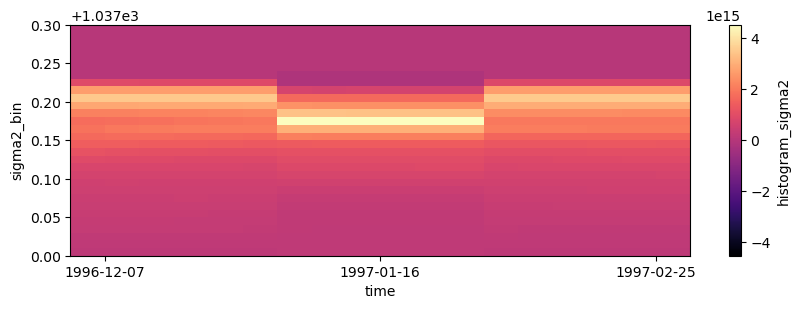

In [99]:
#01-28-1997 causing strange distribution
sigma_dist.sel(time=slice('1996-12', '1997-02')).plot(x='time', figsize=(10,3), cmap='magma')
plt.ylim(1037, 1037.3)

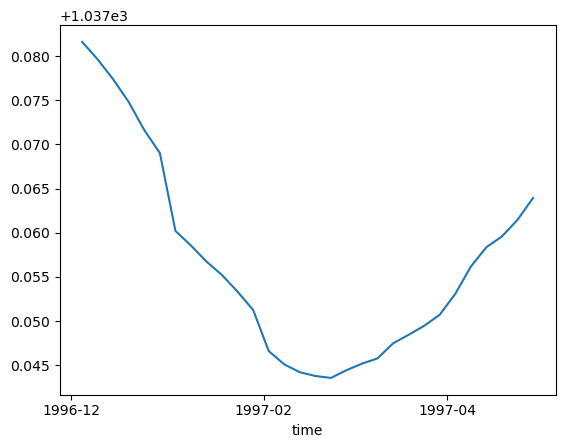

In [100]:
sigma2.sel(time=slice('1996-12', '1997-04')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

#### Adjusting for another spike in Jan of 1997 
for `sigma2` and `sigma_dist` variables

In [101]:
#for sigma2
dec = sigma2.sel(time='1996-12')
feb = sigma2.sel(time='1997-02')
jan = sigma2.sel(time='1997-01')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into sigma2 ds
for i in range(6):
    for j in jan_range:
        sigma2[j] = jan[i]

In [102]:
#for sigma_dist
dec = sigma_dist.sel(time='1996-12')
feb = sigma_dist.sel(time='1997-02')
jan = sigma_dist.sel(time='1997-01')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into sigma_dist ds
for i in range(6):
    for j in jan_range:
        sigma_dist[j] = jan[i]

(1037.0, 1037.3)

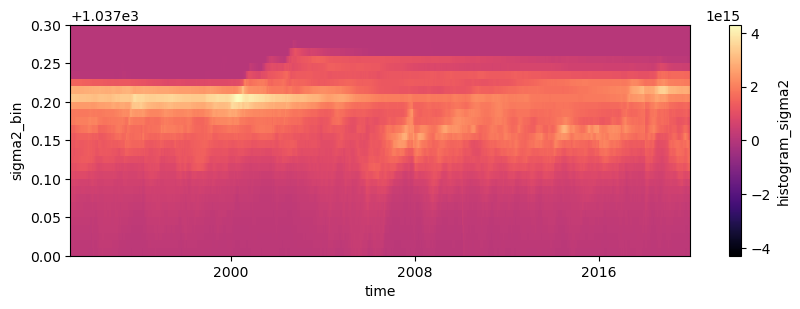

In [103]:
#got rid of spike in jan 1997
sigma_dist.plot(x='time', figsize=(10,3), cmap='magma')
plt.ylim(1037, 1037.3)

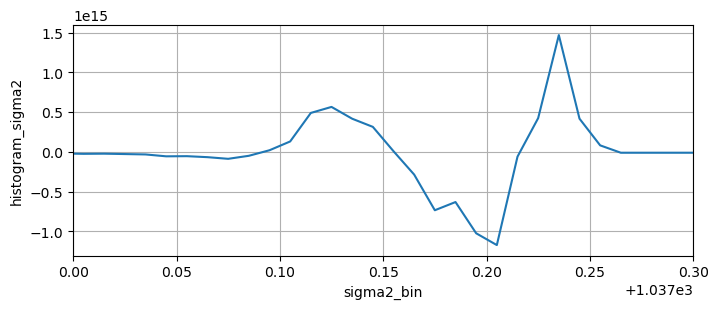

In [104]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1037, 1037.3)
plt.grid();

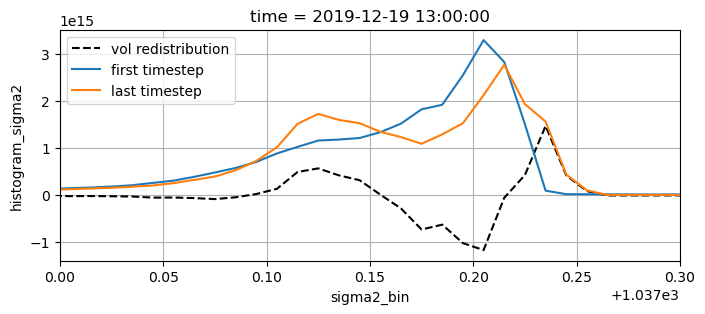

In [105]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

In [106]:
first_timestp = sigma_dist[0].sel(sigma2_bin=slice(1037.195, None)).sum()
last_timestp = sigma_dist[-1].sel(sigma2_bin=slice(1037.195, None)).sum()

last_timestp - first_timestp

<xarray.DataArray 'histogram_sigma2' ()>
array(1.07618938e+15)

#### Need to redescribe after changing sigma bin range and size

- 1037.0-1037.08: volume is lost (2nd plot), negative lobe meaning volume is decreasing (1st plot, black dash), 

- 1037.10-1037.16: volume is added (2nd plot), positive lobe meaning volume is increasing (1st plot, black dash), negative slope for majority of this interval, meaning the rate of volume redistribution is decreasing so therefore, more water buildup of waters in this range bc of less distribution of the waters (that’s why you see more volume in “last timestep” and positive lobe in 1st plot). 

- 1037.16-1037.22: volume is lost (2nd plot), negative lobe meaning volume is decreasing (1st plot, black dash), first half of this interval is negative slope (1st plot) but since it's a negative lobe this negative slope means the vol redistribution is increasing (that's why there's a larger gap in first half of this interval (2nd plot) than the second half which is associated with a positive slope (still in negative lobe) so that means decrease in redistribution rate of cum vol.

- 1037.22-1037.26: volume is added (2nd plot), positive lobe meaning volume is increasing (1st plot, black dash), mostly negative slope meaning decreased rate of volume redistribution meaning waters in this range are being distributed at a slower rate (that’s why you see more volume in “last timestep” and positive lobe in 1st plot).

## <font color='Green'>\begin{equation*} \frac{\partial \mathcal{V}}{\partial t} \end{equation*}</font>

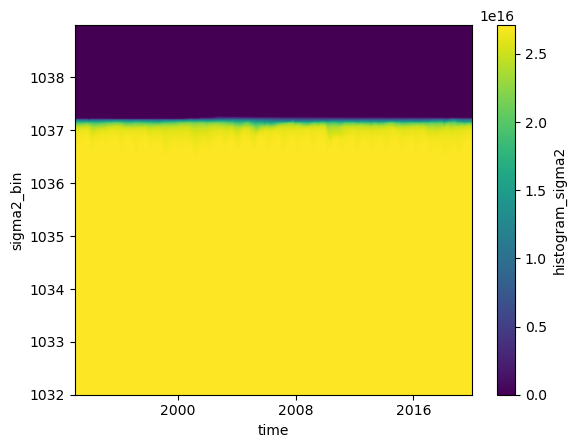

In [107]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
#plt.ylim(1037.5, 1036.4)

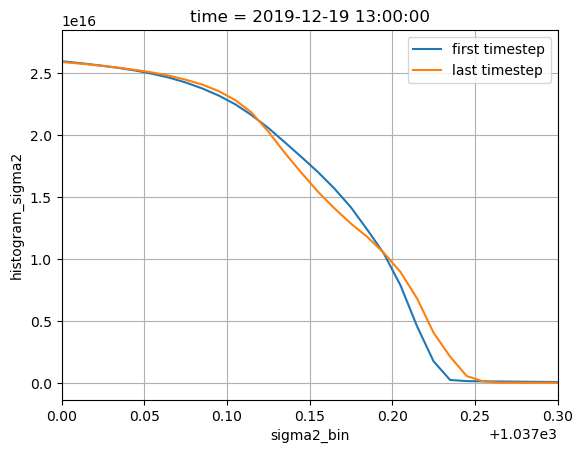

In [47]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

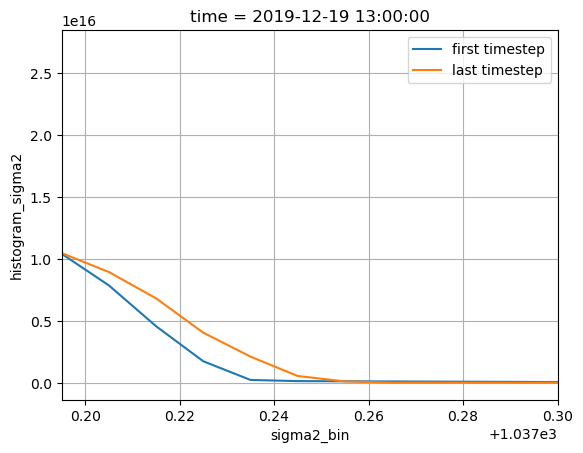

In [48]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.195, 1037.3)
plt.grid();

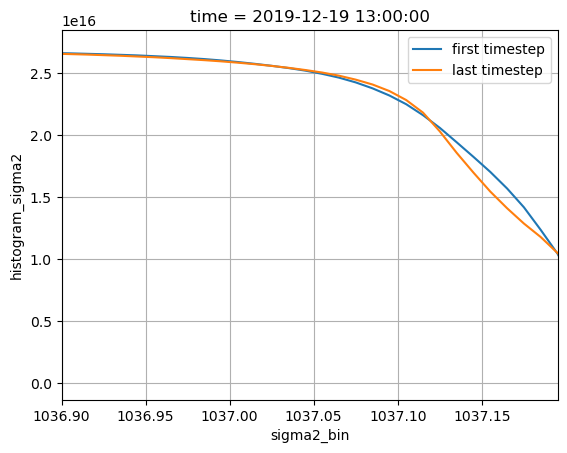

In [49]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.9, 1037.195)
plt.grid();

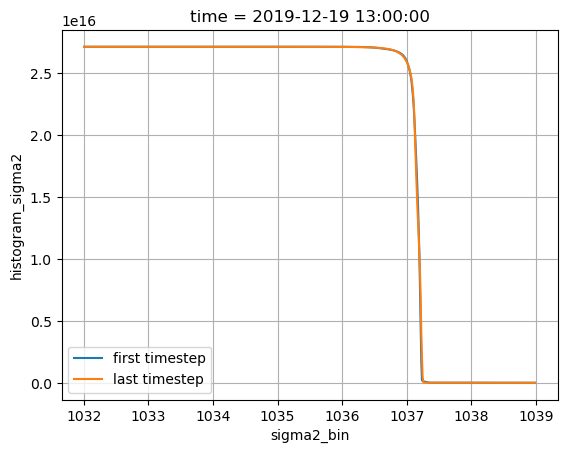

In [50]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

In [108]:
delta_V = V.diff(dim='time')

In [109]:
dVdt = (delta_V / surf.dt[1:]).drop('dt')

In [110]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.77777778e-05, -2.77777778e-05, -2.77777778e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.62962963e-05,  4.62962963e-05,  4.62962963e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.25925926e-06, -9.25925926e-06, -9.25925926e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.03703704e-04,  2.03703704e-04,  2.03703704e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.48148148e-05, -6.48148148e-05, -6.48148148e-05]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1036.0, 1037.3)

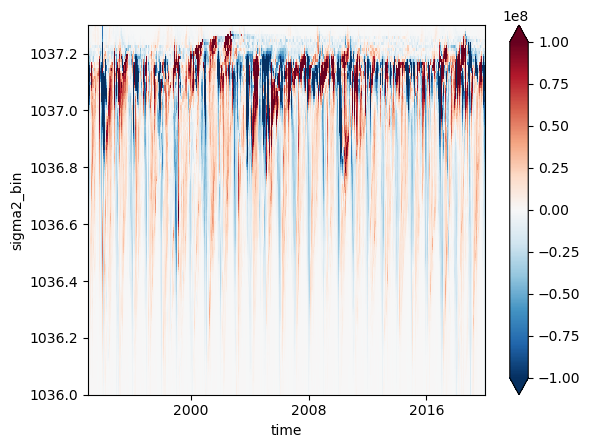

In [54]:
dVdt.plot(x='time', vmax=1e8, yincrease=False)
plt.ylim(1036, 1037.3)

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \sigma_2 \end{equation*}</font>

In [21]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center

In [22]:
xgcm.__version__

'0.8.0'

In [23]:
t = 20

In [36]:
#truncating xt,yt so that xu,yu encompass the entire T cell region
transport_trunc = transport.isel(xt_ocean=slice(1, -1), yt_ocean=slice(None, -1))

In [37]:
transport_trunc.coords

Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean        (xt_ocean) float64 -64.88 -64.62 -64.38 ... 29.38 29.62
  * xu_ocean        (xu_ocean) float64 -65.0 -64.75 -64.5 ... 29.5 29.75 30.0
  * yt_ocean        (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.49 -57.36
  * yu_ocean        (yu_ocean) float64 -79.97 -79.86 -79.76 ... -57.29 -57.16

In [38]:
transport_trunc.tx_int.isel(time=t, xu_ocean=0).coords

Coordinates:
    time      object 1993-07-26 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.63 -57.49 -57.36

In [39]:
transport_trunc.tx_int.isel(time=t, xu_ocean=-1).coords

Coordinates:
    time      object 1993-07-26 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.63 -57.49 -57.36

In [40]:
transport_trunc.ty_int.isel(time=t, yu_ocean=-1).coords

Coordinates:
    time      object 1993-07-26 01:00:00
  * xt_ocean  (xt_ocean) float64 -64.88 -64.62 -64.38 ... 29.12 29.38 29.62
    yu_ocean  float64 -57.16

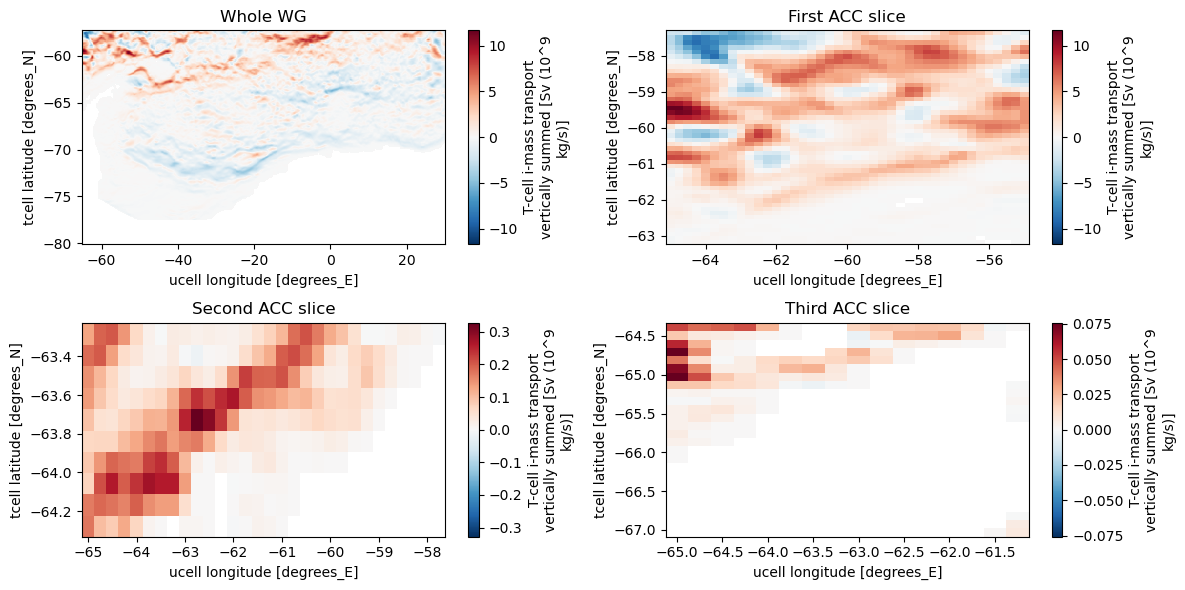

In [69]:
fig, ax = plt.subplots(2,2, figsize=(12,6))

transport_trunc.tx_int[t].plot(ax=ax[0,0])
ax[0,0].set_title('Whole WG')
transport_trunc.tx_int[t,159:None, None:41].plot(ax=ax[0,1])
ax[0,1].set_title('First ACC slice')
transport_trunc.tx_int[t,149:159, None:30].plot(ax=ax[1,0])
ax[1,0].set_title('Second ACC slice')
transport_trunc.tx_int[t,123:149, None:16].plot(ax=ax[1,1])
ax[1,1].set_title('Third ACC slice')

plt.tight_layout();

In [6]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [137]:
#define the slices to exclude ACC influence on budget
#For transport terms

x1 = 41
y1 = 159
x2 = 30
y2 = 149
x3 = 16
y3 = 123

def sliced(y, x, y_coord, x_coord, slicing=False, *ys, xs):
    """Simple func to select corner slices according to variable's coordinates.
        Input sets: x,y ranges of each slice, specified coordinate *names* of each variable. 
        Possible combos ([(t,t), (u,u), (yt,xu), (yu,xt)])."""
    
    if slicing:
        cs = {y_coord:y, x_coord:x}
    else:
        cs = {y_coord:slice(y, ys), x_coord:slice(x,xs)}
        
    
    return(cs)

In [130]:
transport_trunc.tx_int.isel(sliced(x1,y1, y_coord=transport_trunc.yt_ocean.name, x_coord=transport_trunc.xu_ocean.name))

<xarray.DataArray 'tx_int' (time: 985, yt_ocean: 48, xu_ocean: 41)>
[1938480 values with dtype=float32]
Coordinates:
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xu_ocean  (xu_ocean) float64 -65.0 -64.75 -64.5 ... -55.5 -55.25 -55.0
  * yt_ocean  (yt_ocean) float64 -63.17 -63.06 -62.94 ... -57.63 -57.49 -57.36
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_t
    long_name:      T-cell i-mass transport vertically summed
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.0000000200408773e+20, 1.0000000200408773e+20]

In [ ]:
#transport terms

#first corner slice

tu1 = transport.tx_int[t].isel(sliced(x1,y1, y_coord=transport_trunc.yt_ocean.name, x_coord=transport_trunc.xu_ocean.name))

In [ ]:
.isel(xu_ocean=slice(41, None), yt_ocean=slice(159,None))

In [41]:
u_transport_right = (transport_trunc.tx_int).isel(time=t, xu_ocean=-1).load()
u_transport_left = (transport_trunc.tx_int).isel(time=t, xu_ocean=0).load()

v_transport = (transport_trunc.ty_int).isel(time=t, yu_ocean=-1).load()

In [42]:
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean']))

v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean'])

residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
float(residual)

-3.7789535522460938

In [132]:
def interp_right_with_land(array, wet_mask):
    # there are several different ways to implement this; this is one
    
    data = wet_mask * np.nan_to_num(array)  # zeros the data on land
    data_shift = np.roll(data, 1, -1)
    
    wet_fac = wet_mask + np.roll(wet_mask, 1, -1)
    # wet_fac = 0: water on left AND right
    # wet_fac = 1: water on left OR right
    # wet_fac = 2: no land nearby
    
    # division by zero creates NaNs
    out =  1 / wet_fac * (data + data_shift)
    
    return np.nan_to_num(out)

In [133]:
wet_mask_full = sigma2.notnull().astype(np.int8)
wet_mask_full

,Array,Chunk
Bytes,7.27 GiB,3.78 MiB
Shape,"(1970, 50, 208, 381)","(1, 50, 208, 381)"
Count,52 Graph Layers,1970 Chunks
Type,int8,numpy.ndarray


In [156]:
u_transport_left.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.49 -57.36 -57.23

In [158]:
transport_y_interp.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xu_ocean  (xu_ocean) float64 -65.0 -64.75 -64.5 -64.25 ... 29.5 29.75 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.49 -57.36 -57.23

In [134]:
sigma_at_tx_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yt_ocean', 'xu_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'xu_ocean': transport.dims['xu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(xu_ocean=transport.xu_ocean)

sigma_at_ty_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yu_ocean', 'xt_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'yu_ocean': transport.dims['yu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(yu_ocean=transport.yu_ocean)


In [135]:
sigma_at_tx_full.equals(sigma_at_tx_full.where(sigma_at_tx_full.notnull()))

True

In [136]:
sigma_at_ty_full.equals(sigma_at_ty_full.where(sigma_at_ty_full.notnull()))

True

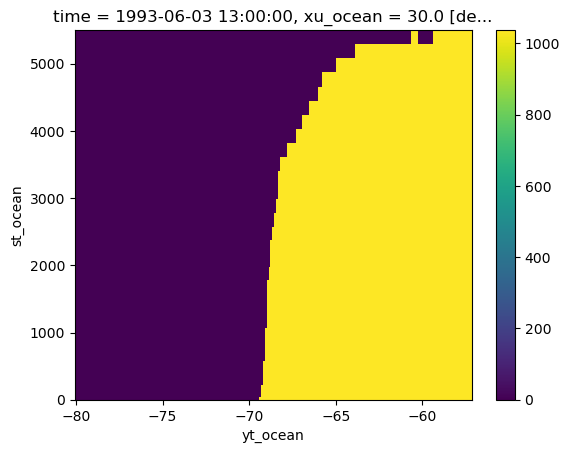

In [201]:
sigma_at_tx_full.isel(xu_ocean=-1)[30].plot()

In [153]:
#interp sigma time dim onto transport time dim
sigma2_u_right_time_interp = sigma_at_tx_full.isel(xu_ocean=-1).interp(time=transport.time)
sigma2_u_left_time_interp = sigma_at_tx_full.isel(xu_ocean=0).interp(time=transport.time)
sigma2_v_time_interp = sigma_at_ty_full.isel(yu_ocean=-1).interp(time=transport.time)

In [154]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma2_u_right_time_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right.fillna(0.), dim=['st_ocean','yt_ocean']).load()
u_binned_left = histogram(sigma2_u_left_time_interp.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left.fillna(0.), dim=['st_ocean','yt_ocean']).load()
v_binned = histogram(sigma2_v_time_interp.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport.fillna(0.), dim=['st_ocean','xt_ocean']).load()

KeyboardInterrupt: 

In [64]:
u_binned_right.sum(dim=('sigma2_bin'))[0].compute()

<xarray.DataArray 'histogram_sigma2' ()>
array(-7.489949, dtype=float32)
Coordinates:
    time     object 1993-01-07 01:00:00

In [65]:
float((-u_binned_left + u_binned_right + v_binned).sum('sigma2_bin').mean(dim='time'))

5.283710956573486

In [67]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 985, sigma2_bin: 699)>
array([[0.       , 0.       , 0.       , ..., 6.558545 , 6.558545 ,
        6.558545 ],
       [0.       , 0.       , 0.       , ..., 9.473615 , 9.473615 ,
        9.473615 ],
       [0.       , 0.       , 0.       , ..., 5.030384 , 5.030384 ,
        5.030384 ],
       ...,
       [0.       , 0.       , 0.       , ..., 5.4048524, 5.4048524,
        5.4048524],
       [0.       , 0.       , 0.       , ..., 6.9304824, 6.9304824,
        6.9304824],
       [0.       , 0.       , 0.       , ..., 5.558859 , 5.558859 ,
        5.558859 ]], dtype=float32)
Coordinates:
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

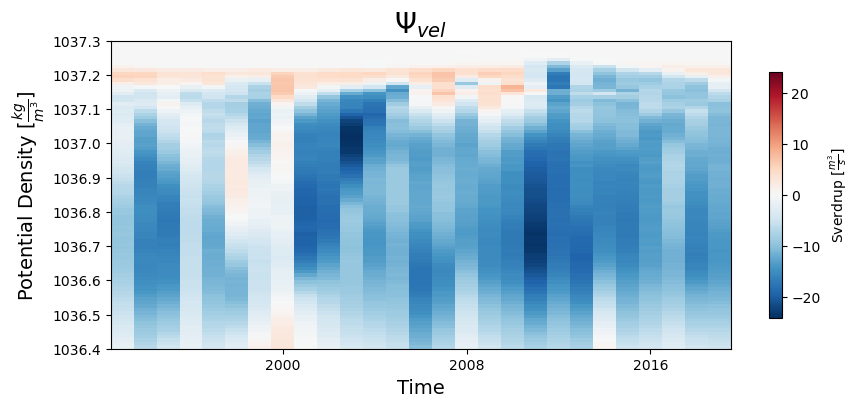

In [68]:
psi_vel.resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

(1036.5, 1037.5)

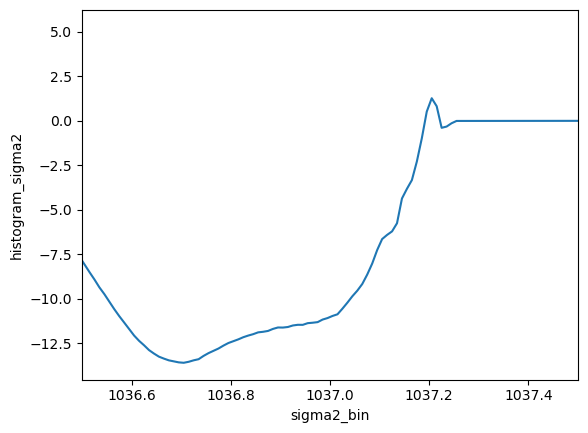

In [69]:
psi_vel.mean(dim='time').plot()
plt.xlim(1036.5, 1037.5)

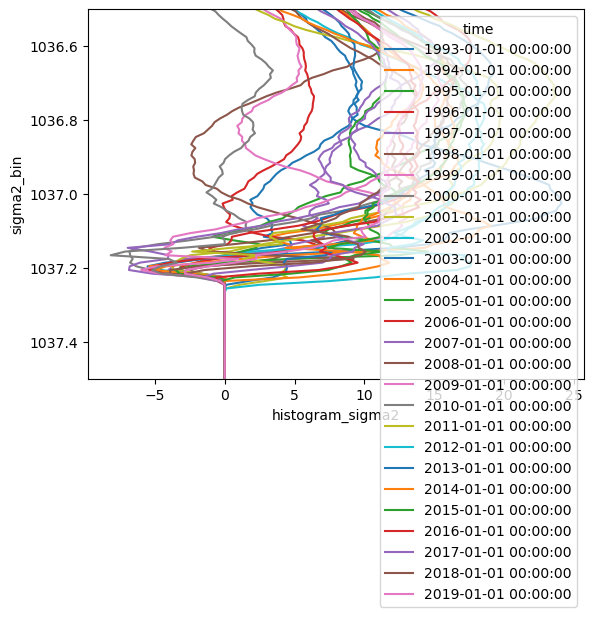

In [214]:
psi_vel.resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
plt.ylim(1037.5, 1036.5);

# <font color='Green'>\begin{equation*} \Omega_{trans} = \frac{\partial V}{\partial t} - \Psi_{vel}\end{equation*} </font>

In [70]:
#omega_tot_interp = omega_total.interp(time=psi_vel.time)
#R1_interp = R1.interp(time=psi_vel.time)
dVdt_interp = dVdt.interp(time=psi_vel.time)

In [71]:
omega_trans = (dVdt_interp/1e6) - psi_vel

In [72]:
omega_trans.load()

<xarray.DataArray (time: 985, sigma2_bin: 699)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ..., -9.47361469,
        -9.47361469, -9.47361469],
       [ 0.        ,  0.        ,  0.        , ..., -5.03038406,
        -5.03038406, -5.03038406],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -5.40485239,
        -5.40485239, -5.40485239],
       [ 0.        ,  0.        ,  0.        , ..., -6.93048239,
        -6.93048239, -6.93048239],
       [ 0.        ,  0.        ,  0.        , ..., -5.55885887,
        -5.55885887, -5.55885887]])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + \Omega_{trans} \end{equation*} </font>

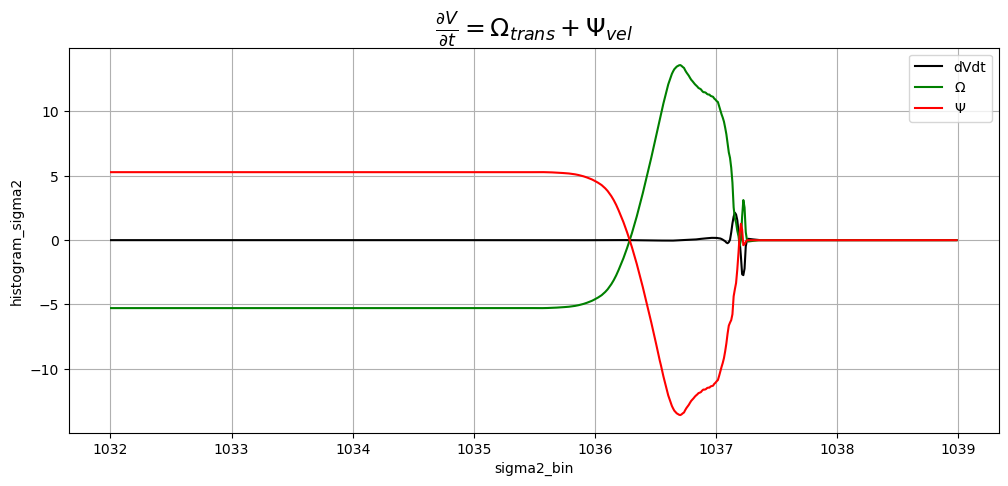

In [85]:
plt.figure(figsize=(12,5))
#(omega_tot_interp/1e6).mean(dim='time').plot(label='tottend', color='k')
(-dVdt_interp/1e6).mean(dim='time').plot(label='dVdt', color='k')
omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
#R2.mean(dim='time').plot(label='R2', color='lightgreen')
psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
#(R1_interp/1e6).mean(dim='time').plot(label='R1', color='blue', linestyle='dashed')
plt.grid()
plt.legend()
#plt.xlim(1036.5, 1037.5)
plt.title(r'$\frac{\partial V}{\partial t} = \Omega_{trans} + \Psi_{vel}$', fontsize=18);

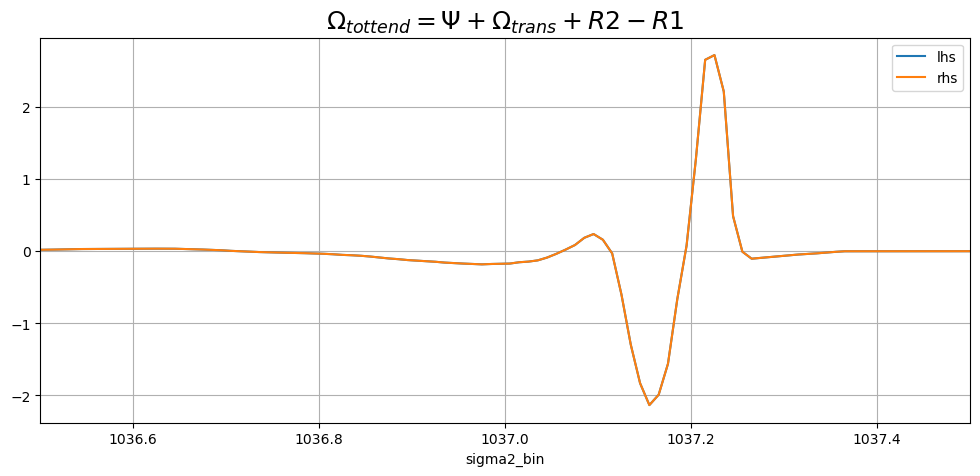

In [87]:
plt.figure(figsize=(12,5))
(dVdt_interp/1e6).mean(dim='time').plot(label='lhs')
(omega_trans + psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

In [75]:
bottom = - (dVdt_interp.isel(sigma2_bin=-1) - 
          dVdt_interp.sel(sigma2_bin=1037.195, method='nearest'))
psi_bot = - (psi_vel.isel(sigma2_bin=-1) - 
             psi_vel.sel(sigma2_bin=1037.195, method='nearest'))
omega_bot = - (omega_trans.isel(sigma2_bin=-1) - 
               omega_trans.sel(sigma2_bin=1037.195, method='nearest'))

In [76]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    anom_rolled = anom.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [77]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [78]:
dVdt_clim = clim(bottom) / 1e6
psi_clim = clim(psi_bot)
omega_clim = clim(omega_bot)

In [81]:
dVdt_anom = anomaly(bottom) / 1e6
psi_anom = anomaly(psi_bot)
omega_anom = anomaly(omega_bot)

/tmp/ipykernel_1051/309839680.py:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
/tmp/ipykernel_1051/309839680.py:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
/tmp/ipykernel_1051/309839680.py:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle


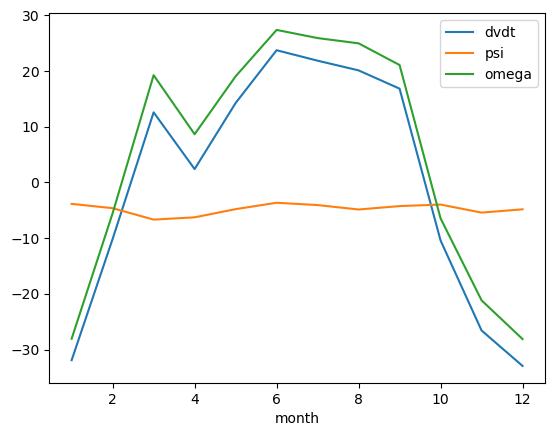

In [79]:
dVdt_clim.plot(label='dvdt')
psi_clim.plot(label='psi')
omega_clim.plot(label='omega')
plt.legend();

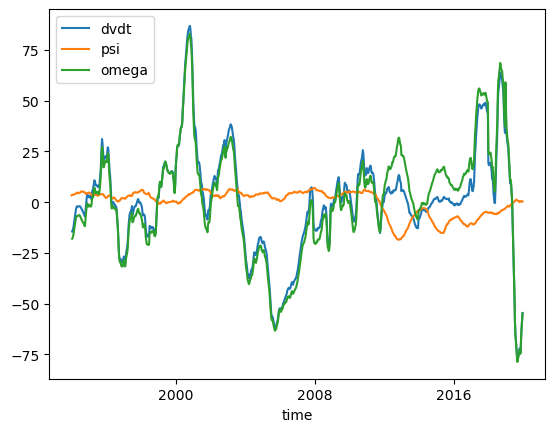

In [82]:
dVdt_anom.plot(label='dvdt')
psi_anom.plot(label='psi')
omega_anom.plot(label='omega')
plt.legend();

# It worked, but there are jumps in salinity from nudging data to fit obs

In [156]:
client.close()
cluster.close()

## Saving Data

In [83]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [84]:
transport = xr.merge([u_binned_right.rename('u_binned_right'), 
                      u_binned_left.rename('u_binned_left'), 
                      v_binned.rename('v_binned'), psi_vel.rename('psi_vel')])

In [235]:
wmt_budget_terms = xr.merge([dVdt_interp.rename('dVdt'), omega_trans.rename('omega_trans'), transport])

In [236]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_trans     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_left   (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned        (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel         (time, sigma2_bin) float32 -6.559 -6.559 ... -0.0 -0.0

In [237]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [246]:
sigma = xr.merge([sigma_dist.rename('sigma_dist'), sigma2.rename('sigma2')])

In [248]:
#uploading sigma2 and sigma_dist
gcsmap_sigma = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/sigma.zarr')
sigma.to_zarr(gcsmap_sigma, mode='w')

In [249]:
client.close()
cluster.close()